<center>
<img src="../../img/ods_stickers.jpg"> 
</center>

## <center> Открытый курс по машинному обучению </center>

### <center> Автор материала: Тетерников Илья (@tetelias) </center>


## <center>Индивидуальный проект по анализу данных:</center>
## <center>Лихорадка Денгэ: предсказание распространения</center>

### 1. Описание набора данных и признаков

#### Введение

Данный материал описывает участие в соревновании "DengAI: Predicting Disease Spread" на портале Drivedata.com. 
Для исследования предоставляется набор данных о выявленных случаях заражения в двух городах: Сан-Хуан, Пуэрто-Рико и Икитос, Перу в течение 18 и 10 лет соответственно. Население городов составляет 395 и 406 тыс. человек, т.е. количества случаев заболевания можно не нормализовывать.

Целью исследования является исследование зависимостей всплесков частоты заболевания от погодных условий. Для проверки требуется предсказать количество выявленных заболеваний в двух городах за период в 5 и 3 года соответственно.

Информация о заболевании из [Википедии](https://en.wikipedia.org/wiki/Dengue_fever):

* Частота заболевания увеличилась в 30 раз за последние 50 лет, и ежегодный ущерб от болезни исчисляется тысячами жизней и миллионами болезней
* Территория распространения болезни расширяется за счет умеренных широт
* Инкубационный период составляет в среднем 1 неделю
* Болезнь легко распространяется и потому может приводить к эпидемиям

Данный вирус переносится комарами рода Aedes, чаще всего вида Aedes aegypti. По этой причине динамика переноса лихорадки связана с климатическими условиями, такими как температура и количество осадков. 

Информация о переносчике заболевания из [Википедии](https://en.wikipedia.org/wiki/Aedes_aegypti): 

* является переносчиком этого и других опасных инфекционных заболеваний
* жизненный цикл - 2-4 недели
* проявляет активность в основном на рассвете и закате 
* проявляет активность круглый год 
* предпочитает стоячую воду
* увеличение численности насекомых связывают с увеличением урбанизации


Данные представляют собой объединение информации из различных источников: Центр по Контролю и Предотврщению Заболеваний США(CDC USA) и Национальное управление океанических и атмосферных исследований США(NOAA).

Глубокое понимание зависимости болезни от погодных условий должно помочь в предотвращении эпидемий. 

---

#### Целевой признак

__total_cases__ - количество выявленных за соответствующую неделю заболеваний
    
__Тестовая выборка__ - последовательная по времени выборка из будущего по отношению к доступным для обучения данным.

#### Признаки:

__city__ – название города: sj - Сан-Хуан и iq - Икитос  
__year__ – год  
__weekofyear__ – номер недели в текущем году  
__week_start_date__ – дата в формате гггг-мм-дд

##### Дневные замеры погодных условий в понедельник каждой недели:

__station_max_temp_c__ – максимальная температура воздуха в течение суток в градусах Цельсия  
__station_min_temp_c__ – минимальная температура воздуха в течение суток в градусах Цельсия  
__station_avg_temp_c__ – средняя температура воздуха в течение суток в градусах Цельсия  
__station_precip_mm__ – размер осадков, измеренный датчиками на поверхности  
__station_diur_temp_rng_c__ – дневные колебания температуры, т.е. изменение температуры в период от восхода до заката, в градусах Цельсия  

__precipitation_amt_mm__ – замер осадков, но произведенный с помощью спутника  

##### Прогнозы погоды:

__reanalysis_sat_precip_amt_mm__ – количество осадков в мм  
__reanalysis_dew_point_temp_k__ – средняя температура росы в градусах Кельвина  
__reanalysis_air_temp_k__ – средняя температура воздуха в течение суток на уровне 2м от земли в градусах Кельвина  
__reanalysis_relative_humidity_percent__ – относительная влажность  
__reanalysis_specific_humidity_g_per_kg__ – абсолютная влажность в г воды на кг воздуха  
__reanalysis_precip_amt_kg_per_m2__ – количество осадков в кг на м2  
__reanalysis_max_air_temp_k__ – максимальная температура воздуха в течение суток в градусах Кельвина  
__reanalysis_min_air_temp_k__ – минимальная температура воздуха в течение суток в градусах Кельвина  
__reanalysis_avg_temp_k__ – средняя температура воздуха в течение суток на уровне земл в градусах Кельвина  
__reanalysis_tdtr_k__ – дневные колебания температуры в градусах Кельвина  

##### Нормализованный ровень растительности на территории:

__ndvi_se__ – юго-восточной части города  
__ndvi_sw__ – юго-западной части города  
__ndvi_ne__ – северо-восточной части города  
__ndvi_nw__ – северо-западной части города  


---

---

### 2. Первичный анализ данных 

---

#### Загрузка данных

In [881]:
# Импортируем необходимые библиотеки для обработки и визуализации данных
from hyperopt import fmin, tpe, rand, hp, STATUS_OK, Trials
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler
from warnings import filterwarnings
filterwarnings('ignore')

import math
import matplotlib.pylab as pylab
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import xgboost as xgb
plt.style.use('ggplot')
%matplotlib inline

Данные предоставлены в виде 3 файлов: признаки для обучения, целевой признак и признаки для предсказания.

In [ ]:
features = pd.read_csv('../../data/dengue_features_train.csv', infer_datetime_format=True)

In [686]:
labels = pd.read_csv('../../data/dengue_labels_train.csv', infer_datetime_format=True)

In [729]:
test = pd.read_csv('../../data/dengue_features_test.csv', infer_datetime_format=True)

In [730]:
train_df = pd.merge(features, labels, how='outer', on=labels.columns.tolist()[:-1])

In [731]:
test_df = test.copy()

In [696]:
train_df.iloc[:, :15].head()

,city,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent
week_start_date,,,,,,,,,,,,,,,
1990-04-30,sj,1990,18,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,299.8,295.9,32.00,73.365714
1990-05-07,sj,1990,19,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,300.9,296.4,17.94,77.368571
1990-05-14,sj,1990,20,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,300.5,297.3,26.10,82.052857
1990-05-21,sj,1990,21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,301.4,297.0,13.90,80.337143
1990-05-28,sj,1990,22,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,301.9,297.5,12.20,80.460000


In [221]:
train_df.iloc[:, 15:].head()

,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
0,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4
1,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5
2,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4
3,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3
4,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6


---

#### Исследование признаков

Два города сильно различаются по климату и качеству сбора информации, поэтому будем рассматривать признаки отдельно по городам

Проверим, все ли данные в наличии:

* как видим, в Сан-Хуане много пропущенных значений по растительности, а в Икитос отсутствует значительная часть наземных замеров климатических условий. 
* есть проблемы и с другими замерами, но там это составляет меньше 1% от общего числа.
* в тестовых выборках ситуация гораздо лучше: проблемы по городам те же самые, но гораздо менее выраженные

---

In [222]:
train_df[train_df.city=='sj'].isnull().sum()

city                                       0
year                                       0
weekofyear                                 0
week_start_date                            0
ndvi_ne                                  191
ndvi_nw                                   49
ndvi_se                                   19
ndvi_sw                                   19
precipitation_amt_mm                       9
reanalysis_air_temp_k                      6
reanalysis_avg_temp_k                      6
reanalysis_dew_point_temp_k                6
reanalysis_max_air_temp_k                  6
reanalysis_min_air_temp_k                  6
reanalysis_precip_amt_kg_per_m2            6
reanalysis_relative_humidity_percent       6
reanalysis_sat_precip_amt_mm               9
reanalysis_specific_humidity_g_per_kg      6
reanalysis_tdtr_k                          6
station_avg_temp_c                         6
station_diur_temp_rng_c                    6
station_max_temp_c                         6
station_mi

In [223]:
train_df[train_df.city=='iq'].isnull().sum()

city                                      0
year                                      0
weekofyear                                0
week_start_date                           0
ndvi_ne                                   3
ndvi_nw                                   3
ndvi_se                                   3
ndvi_sw                                   3
precipitation_amt_mm                      4
reanalysis_air_temp_k                     4
reanalysis_avg_temp_k                     4
reanalysis_dew_point_temp_k               4
reanalysis_max_air_temp_k                 4
reanalysis_min_air_temp_k                 4
reanalysis_precip_amt_kg_per_m2           4
reanalysis_relative_humidity_percent      4
reanalysis_sat_precip_amt_mm              4
reanalysis_specific_humidity_g_per_kg     4
reanalysis_tdtr_k                         4
station_avg_temp_c                       37
station_diur_temp_rng_c                  37
station_max_temp_c                       14
station_min_temp_c              

In [224]:
test_df[test_df.city=='sj'].isnull().sum()

city                                      0
year                                      0
weekofyear                                0
week_start_date                           0
ndvi_ne                                  43
ndvi_nw                                  11
ndvi_se                                   1
ndvi_sw                                   1
precipitation_amt_mm                      2
reanalysis_air_temp_k                     2
reanalysis_avg_temp_k                     2
reanalysis_dew_point_temp_k               2
reanalysis_max_air_temp_k                 2
reanalysis_min_air_temp_k                 2
reanalysis_precip_amt_kg_per_m2           2
reanalysis_relative_humidity_percent      2
reanalysis_sat_precip_amt_mm              2
reanalysis_specific_humidity_g_per_kg     2
reanalysis_tdtr_k                         2
station_avg_temp_c                        2
station_diur_temp_rng_c                   2
station_max_temp_c                        2
station_min_temp_c              

In [225]:
test_df[test_df.city=='iq'].isnull().sum()

city                                      0
year                                      0
weekofyear                                0
week_start_date                           0
ndvi_ne                                   0
ndvi_nw                                   0
ndvi_se                                   0
ndvi_sw                                   0
precipitation_amt_mm                      0
reanalysis_air_temp_k                     0
reanalysis_avg_temp_k                     0
reanalysis_dew_point_temp_k               0
reanalysis_max_air_temp_k                 0
reanalysis_min_air_temp_k                 0
reanalysis_precip_amt_kg_per_m2           0
reanalysis_relative_humidity_percent      0
reanalysis_sat_precip_amt_mm              0
reanalysis_specific_humidity_g_per_kg     0
reanalysis_tdtr_k                         0
station_avg_temp_c                       10
station_diur_temp_rng_c                  10
station_max_temp_c                        1
station_min_temp_c              

---
Взглянем на переходы из года в год:
* становится понятна природа части недостающих данных: люди празднуют новый год и им не до фиксирования замеров
* некоторые недели приписаны к следующему году, что нужно исправить

---

In [226]:
train_df[(train_df.weekofyear==1)|(train_df.weekofyear==52)|(train_df.weekofyear==53)].iloc[:, :15]

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2
34,sj,1990,52,1990-12-24,0.302500,0.277233,0.171267,0.161622,0.00,298.038571,298.085714,292.105714,299.8,295.3,5.46
35,sj,1991,1,1991-01-01,0.146500,0.140467,0.151500,0.167314,0.00,297.060000,297.135714,291.907143,299.0,293.9,4.80
86,sj,1991,52,1991-12-24,0.123550,0.123700,0.137933,0.129756,0.00,296.521429,296.507143,292.045714,299.2,294.3,19.30
87,sj,1992,1,1992-01-01,0.125100,0.157867,0.185283,0.181367,NaN,NaN,NaN,NaN,NaN,NaN,NaN
138,sj,1992,52,1992-12-23,-0.010080,0.068217,0.086900,0.073313,0.00,297.172857,297.350000,292.800000,299.1,296.1,23.80
139,sj,1993,53,1993-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
140,sj,1993,1,1993-01-08,0.028350,0.043667,0.078657,0.046457,46.79,297.467143,297.550000,294.150000,299.4,296.1,41.90
191,sj,1994,52,1994-01-01,NaN,NaN,NaN,NaN,5.25,298.527143,298.778571,294.401429,301.0,296.0,3.40
192,sj,1994,1,1994-01-08,-0.120900,0.019300,0.094986,0.178514,12.60,298.191429,298.285714,293.585714,300.1,296.3,19.50
243,sj,1995,52,1995-01-01,0.243800,0.045000,0.215256,0.194778,71.43,298.838571,299.107143,295.674286,301.5,296.7,30.40


In [732]:
train_df.year = np.where((train_df.week_start_date.apply(lambda x: x[5:]) == '01-01')&(train_df.weekofyear != 1),
                         train_df.year-1, train_df.year)
test_df.year = np.where((test_df.week_start_date.apply(lambda x: x[5:]) == '01-01')&(test_df.weekofyear != 1),
                         test_df.year-1, test_df.year)

In [733]:
train_df = train_df.sort_values(by='week_start_date')

In [734]:
train_df.week_start_date = train_df.week_start_date.apply(pd.to_datetime)
train_df.set_index('week_start_date', inplace=True)

In [735]:
test_df.set_index('week_start_date', inplace=True)

---

Теперь посмотрим на распределение признаков:

* значения признаков не противоречат природе данных
* уровень растительности в Сан-Хуане принимает отрицательные значения, что связано с нормализацией
* разброс температур и количество осадков значительно меньше в Сан-Хуане
* в признаках, связанных с растительностью в Сан-Хуане и количеством осадков в обоих городах, мы наблюдаем выбросы

---

In [694]:
cols = train_df.columns[1:3].tolist() + train_df.columns[3:25].tolist()

In [695]:
train_df[train_df.city=='sj'][cols[:13]].describe()

,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2
count,936.000000,936.000000,745.000000,887.000000,917.000000,917.000000,927.000000,930.000000,930.000000,930.000000,930.000000,930.000000,930.000000
mean,1998.819444,26.503205,0.057925,0.067469,0.177655,0.165956,35.470809,299.163653,299.276920,295.109519,301.398817,297.301828,30.465419
std,5.212745,15.021909,0.107153,0.092479,0.057166,0.056073,44.606137,1.236429,1.218637,1.569943,1.258927,1.294705,35.628055
min,1990.000000,1.000000,-0.406250,-0.456100,-0.015533,-0.063457,0.000000,295.938571,296.114286,289.642857,297.800000,292.600000,0.000000
25%,1994.000000,13.750000,0.004500,0.016425,0.139283,0.129157,0.000000,298.195000,298.300000,293.847857,300.400000,296.300000,10.825000
50%,1999.000000,26.500000,0.057700,0.068075,0.177186,0.165971,20.800000,299.254286,299.378571,295.464286,301.500000,297.500000,21.300000
75%,2003.000000,39.250000,0.111100,0.115200,0.212557,0.202771,52.180000,300.132857,300.228571,296.418929,302.400000,298.400000,37.000000
max,2008.000000,53.000000,0.493400,0.437100,0.393129,0.381420,390.600000,302.200000,302.164286,297.795714,304.300000,299.900000,570.500000


In [230]:
train_df[train_df.city=='iq'][cols[:13]].describe()

,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k
count,520.000000,520.000000,517.000000,517.000000,517.000000,517.000000,516.000000,516.000000,516.000000,516.000000,516.000000,516.000000
mean,2004.994231,26.503846,0.263869,0.238783,0.250126,0.266779,64.245736,297.869538,299.133043,295.492982,307.082752,292.866667
std,2.915305,15.029450,0.081370,0.076751,0.077354,0.086345,35.218995,1.170997,1.332073,1.417229,2.382980,1.663069
min,2000.000000,1.000000,0.061729,0.035860,0.029880,0.064183,0.000000,294.635714,294.892857,290.088571,300.000000,286.900000
25%,2002.750000,13.750000,0.200000,0.179540,0.194743,0.204129,39.105000,297.092500,298.221429,294.593929,305.200000,291.975000
50%,2005.000000,26.500000,0.263643,0.232971,0.249800,0.262143,60.470000,297.822857,299.121429,295.852143,307.050000,293.050000
75%,2007.250000,39.250000,0.319971,0.293929,0.302300,0.325150,85.757500,298.649286,300.123214,296.548571,308.700000,294.200000
max,2010.000000,53.000000,0.508357,0.454429,0.538314,0.546017,210.830000,301.637143,302.928571,298.450000,314.000000,296.000000


In [231]:
train_df[train_df.city=='sj'][cols[13:]].describe()

,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
count,930.000000,930.000000,927.000000,930.000000,930.000000,930.000000,930.000000,930.000000,930.000000,930.000000,936.000000
mean,30.465419,78.568181,35.470809,16.552409,2.516267,27.006528,6.757373,31.607957,22.600645,26.785484,34.180556
std,35.628055,3.389488,44.606137,1.560923,0.498892,1.415473,0.835993,1.717297,1.506277,29.325811,51.381372
min,0.000000,66.735714,0.000000,11.715714,1.357143,22.842857,4.528571,26.700000,17.800000,0.000000,0.000000
25%,10.825000,76.246071,0.000000,15.236429,2.157143,25.842857,6.200000,30.600000,21.700000,6.825000,9.000000
50%,21.300000,78.667857,20.800000,16.845714,2.457143,27.228571,6.757143,31.700000,22.800000,17.750000,19.000000
75%,37.000000,80.963214,52.180000,17.858571,2.800000,28.185714,7.285714,32.800000,23.900000,35.450000,37.000000
max,570.500000,87.575714,390.600000,19.440000,4.428571,30.071429,9.914286,35.600000,25.600000,305.900000,461.000000


In [232]:
train_df[train_df.city=='iq'][cols[13:]].describe()

,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
count,516.000000,516.000000,516.000000,516.000000,516.000000,483.000000,483.000000,506.000000,512.000000,504.000000,520.000000
mean,57.609864,88.639117,64.245736,17.096110,9.206783,27.530933,10.566197,34.004545,21.196680,62.467262,7.565385
std,50.286555,7.583889,35.218995,1.445769,2.448525,0.921769,1.535496,1.325261,1.260327,63.245958,10.765478
min,0.000000,57.787143,0.000000,12.111429,3.714286,21.400000,5.200000,30.100000,14.700000,0.000000,0.000000
25%,24.065000,84.295000,39.105000,16.102857,7.371429,27.000000,9.500000,33.200000,20.600000,17.200000,1.000000
50%,46.440000,90.917143,60.470000,17.428571,8.964286,27.600000,10.625000,34.000000,21.300000,45.300000,5.000000
75%,71.072500,94.563929,85.757500,18.180357,11.014286,28.100000,11.655000,34.900000,22.000000,85.950000,9.000000
max,362.030000,98.610000,210.830000,20.461429,16.028571,30.800000,15.800000,42.200000,24.200000,543.300000,116.000000


---
Найдем пары признаков с максимальной корреляцией:

---

In [233]:
def mostcorr(dataframe, numtoreport):
    
    cormatrix = dataframe.corr()
    
    cormatrix *= np.tri(*cormatrix.values.shape, k=-1).T
    
    cormatrix = cormatrix.stack()
    cormatrix = cormatrix.reindex(cormatrix.abs().sort_values(ascending=False).index).reset_index()
    
    cormatrix.columns = ["Признак №1", "Признак №2", "Корреляция"]
    return cormatrix.head(numtoreport)

In [234]:
mostcorr(train_df[train_df.city=='sj'],10)

,Признак №1,Признак №2,Корреляция
0,precipitation_amt_mm,reanalysis_sat_precip_amt_mm,1.000000
1,reanalysis_dew_point_temp_k,reanalysis_specific_humidity_g_per_kg,0.998532
2,reanalysis_air_temp_k,reanalysis_avg_temp_k,0.997495
3,reanalysis_air_temp_k,reanalysis_min_air_temp_k,0.942254
4,reanalysis_avg_temp_k,reanalysis_min_air_temp_k,0.939120
5,reanalysis_avg_temp_k,reanalysis_max_air_temp_k,0.938952
6,reanalysis_air_temp_k,reanalysis_max_air_temp_k,0.935089
7,reanalysis_air_temp_k,reanalysis_specific_humidity_g_per_kg,0.904819
8,reanalysis_air_temp_k,reanalysis_dew_point_temp_k,0.903287
9,reanalysis_dew_point_temp_k,reanalysis_min_air_temp_k,0.898814


In [235]:
mostcorr(train_df[train_df.city=='iq'],10)

,Признак №1,Признак №2,Корреляция
0,precipitation_amt_mm,reanalysis_sat_precip_amt_mm,1.000000
1,reanalysis_dew_point_temp_k,reanalysis_specific_humidity_g_per_kg,0.997775
2,reanalysis_air_temp_k,reanalysis_avg_temp_k,0.973319
3,reanalysis_relative_humidity_percent,reanalysis_tdtr_k,-0.896491
4,ndvi_ne,ndvi_sw,0.842784
5,reanalysis_max_air_temp_k,reanalysis_tdtr_k,0.799293
6,reanalysis_avg_temp_k,reanalysis_max_air_temp_k,0.783955
7,ndvi_ne,ndvi_se,0.767745
8,ndvi_nw,ndvi_sw,0.764829
9,ndvi_ne,ndvi_nw,0.764407


* Температура в Сан-Хуане изменяется слабо в течение дня, а абсолютная влажность движется вслед за температурой. 
* В Икитос количество вегетации в различных частях города имеет очень сильную корреляцию.
* Наконец, нельзя не отметить, что три пары с наибольше корреляцией совпадают для обоих городов и едва отличимы от 1, так что удалим reanalysis_sat_precip_amt_mm, reanalysis_dew_point_temp_k, reanalysis_avg_temp_k:

In [736]:
del train_df['reanalysis_sat_precip_amt_mm']
del train_df['reanalysis_dew_point_temp_k']
del train_df['reanalysis_avg_temp_k']
del test_df['reanalysis_sat_precip_amt_mm']
del test_df['reanalysis_dew_point_temp_k']
del test_df['reanalysis_avg_temp_k']

---
Посмотрим на связь признаков с целевой переменной:

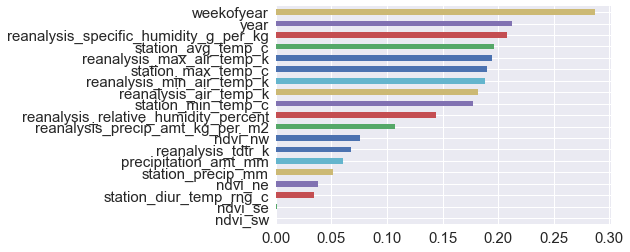

In [411]:
sns.set(font_scale = 1.5)
(abs(train_df[(train_df.city=='sj')].corr())
 .total_cases
 .drop('total_cases')
 .sort_values()
 .plot
 .barh())

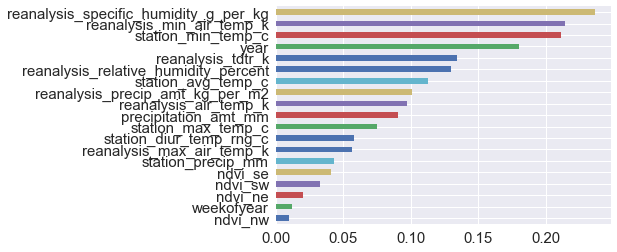

In [412]:
sns.set(font_scale = 1.5)
(abs(train_df[(train_df.city=='iq')].corr())
 .total_cases
 .drop('total_cases')
 .sort_values()
 .plot
 .barh())

Часть признаков присутствует в обоих группах.
Это означает, что абсолютная влажность и оба замера минимальной температуры воздуха могут быть наиболее полезны в предсказании целевого признака. Интересно также присутствие признака 'year'.

---

#### Исследование целевого признака

Рассмотрим график относительной частотности количества случаев заболевания для двух городов. Оба распределения явно относятся к отрицательным биномиальным.

Text(0.5,0.98,'Количество случаев')

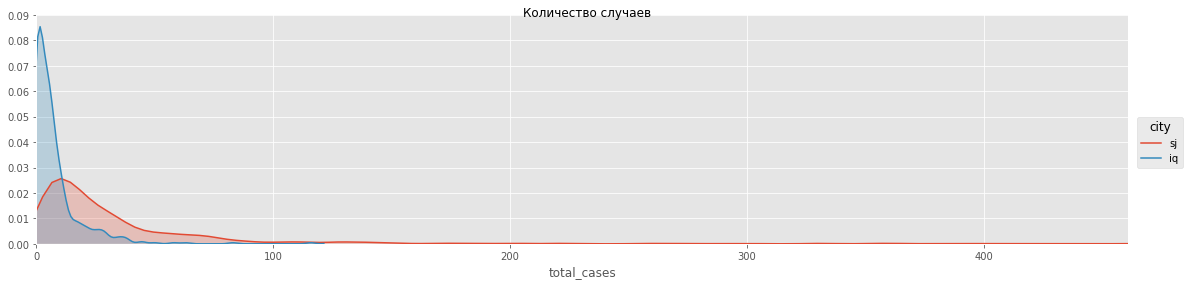

In [277]:
fig = sns.FacetGrid(train_df, hue='city', aspect=4, size=4) 
fig.map(sns.kdeplot,'total_cases',shade=True)
max_x = train_df.total_cases.max()
min_x = train_df.total_cases.min()
fig.set(xlim=(min_x,max_x))
fig.set(ylim=(0, 0.09))
fig.add_legend()
fig.fig.suptitle("Количество случаев")

Несмотря на визуальную разницу распределения отличаются только масштабом:

In [335]:
train_df['total_cases_temp'] = train_df.total_cases.where(train_df.city=='sj', train_df.total_cases*3.3)

Text(0.5,0.98,'Количество случаев масштабированное')

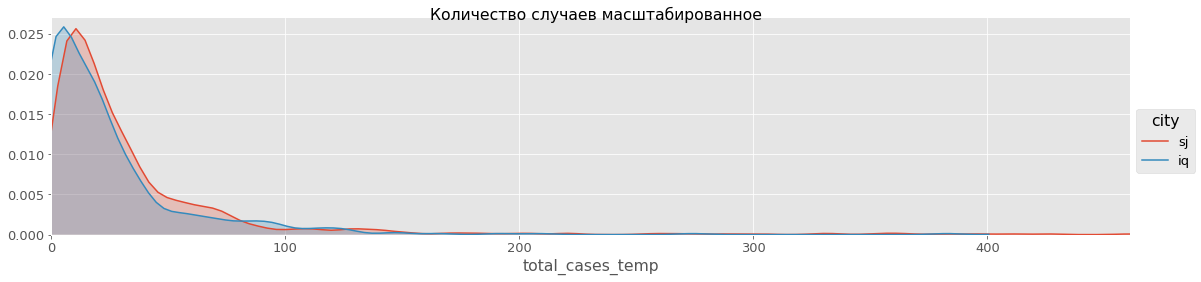

In [336]:
fig = sns.FacetGrid(train_df, hue='city', aspect=4, size=4) 
fig.map(sns.kdeplot,'total_cases_temp',shade=True)
max_x = train_df.total_cases.max()
min_x = train_df.total_cases.min()
fig.set(xlim=(min_x,max_x))
fig.add_legend()
fig.fig.suptitle("Количество случаев масштабированное")

In [337]:
del train_df['total_cases_temp']

Вычислим параметры распределений для целевой переменной: скошенность, а также p и r.

In [288]:
sj_std = train_df[train_df.city=='sj'].total_cases.std()
sj_mean = train_df[train_df.city=='sj'].total_cases.mean()
sj_median = train_df[train_df.city=='sj'].total_cases.median()
iq_std = train_df[train_df.city=='iq'].total_cases.std()
iq_mean = train_df[train_df.city=='iq'].total_cases.mean()
iq_median = train_df[train_df.city=='iq'].total_cases.median()

#Скошенность
sj_skew = (sj_mean - sj_median) / sj_std
iq_skew = (iq_mean - iq_median) / iq_std

#p
sj_p = 1 - sj_mean / sj_std**2
iq_p = 1 - iq_mean / iq_std**2

#r
sj_r = sj_mean**2 / sj_std**2 / sj_p
iq_r = iq_mean**2 / iq_std**2 / iq_p

print('Скошенность распределения целевой переменной для Сан-Хуана равна:%0.3f' % sj_skew)
print('Скошенность распределения целевой переменной для Икитос равна:%0.3f' % iq_skew)
print('')
print('Параметры p и r распределения целевой переменной для Сан-Хуана равны:%0.3f' % sj_p + ' и %0.3f' % sj_r)
print('Параметры p и r распределения целевой переменной для Икитос равны:%0.3f' % iq_p + ' и %0.3f' % iq_r)

Скошенность распределения целевой переменной для Сан-Хуана равна:0.295
Скошенность распределения целевой переменной для Икитос равна:0.238

Параметры p и r распределения целевой переменной для Сан-Хуана равны:0.987 и 0.448
Параметры p и r распределения целевой переменной для Икитос равны:0.935 и 0.528


Это еще одно доказательство схожести распределений целевой переменной для обоих городов

---

Посмотрим на историческое распределение случаев заболевания в обоих городах:

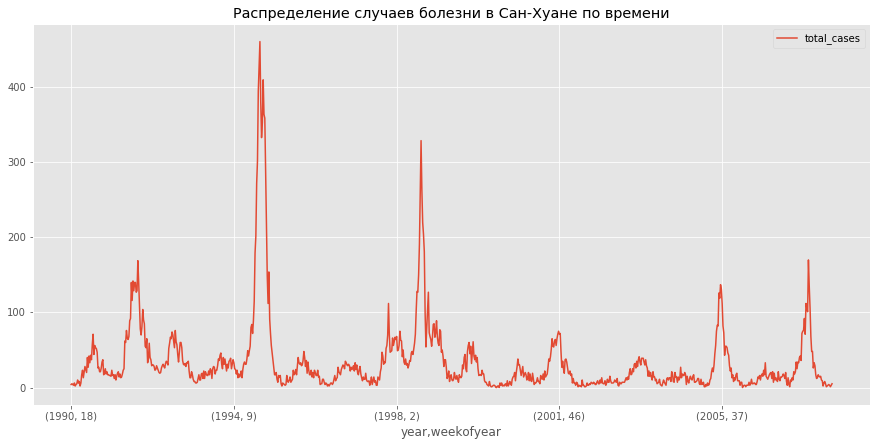

In [174]:
train_df[train_df.city=='sj'].plot(kind='line',  x=['year', 'weekofyear'], y='total_cases',
              figsize=[15,7],title='Распределение случаев болезни в Сан-Хуане по времени')

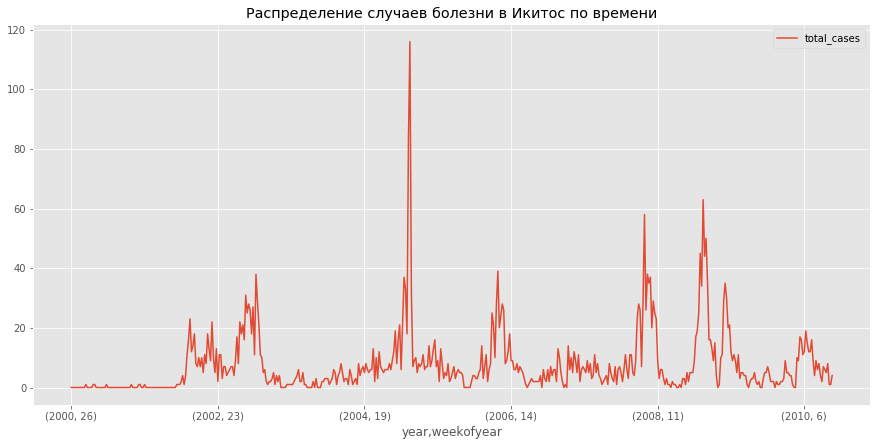

In [173]:
train_df[train_df.city=='iq'].plot(kind='line',  x=['year', 'weekofyear'], y='total_cases',
              figsize=[15,7],title='Распределение случаев болезни в Икитос по времени')

Данные по Икитос шумнее, но в целом видно, что всплески заболевания имеют схожую продолжительность.

---

Теперь посмотрим на распределение случаев заболевания понедельно:

Text(0.5,0.98,'Распределение случаев болезни в течение года')

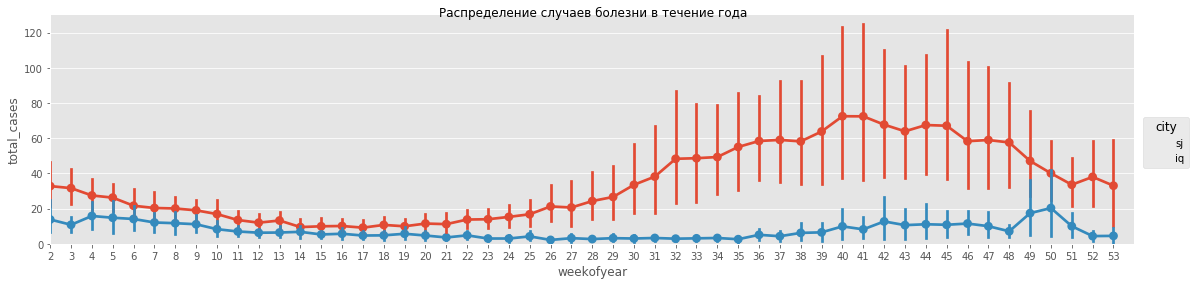

In [181]:
fig = sns.FacetGrid(train_df, hue='city', aspect=4, size=4) 
fig.map(sns.pointplot,'weekofyear','total_cases')
max_x = train_df.weekofyear.max()
min_x = train_df.weekofyear.min()
fig.set(xlim=(min_x,max_x))
fig.set(ylim=(0, 130))
fig.add_legend()
fig.fig.suptitle("Распределение случаев болезни в течение года")

Наблюдается интересная сезонность с минимумом в районе 13-19 недель и максимумом - 40-46. Более точные выводы невозможно сделать ввиду малого размера выборки.

Для приближения распределения целевого признака к нормальной форме используем операцию логарифмирования:

In [737]:
train_df['total_cases_adj'] = train_df.total_cases.apply(math.log1p)

---

---

### 3. Первичный визуальный анализ данных

---

Принимая во внимание срок инкубации и жизненный цикл распространителя, попробуем рассмотреть влияние текущих погодных условий на уровень заболевания в будущем на 1, 2, 3 и 4 недели. Для этого создадим новые переменные из целевой сдвигом на соответствующее число недель.

In [349]:
sj_df = train_df[train_df.city=='sj'].copy()
iq_df = train_df[train_df.city=='iq'].copy()
for i in range(1, 5):
    sj_df['total_cases'+str(i)] = sj_df.total_cases.shift(i)
    iq_df['total_cases'+str(i)] = iq_df.total_cases.shift(i)
    
train_df = pd.concat((sj_df, iq_df))

Так как города имеют разный климат, взглянем на взаимодействие признаков для каждого из них отдельно:

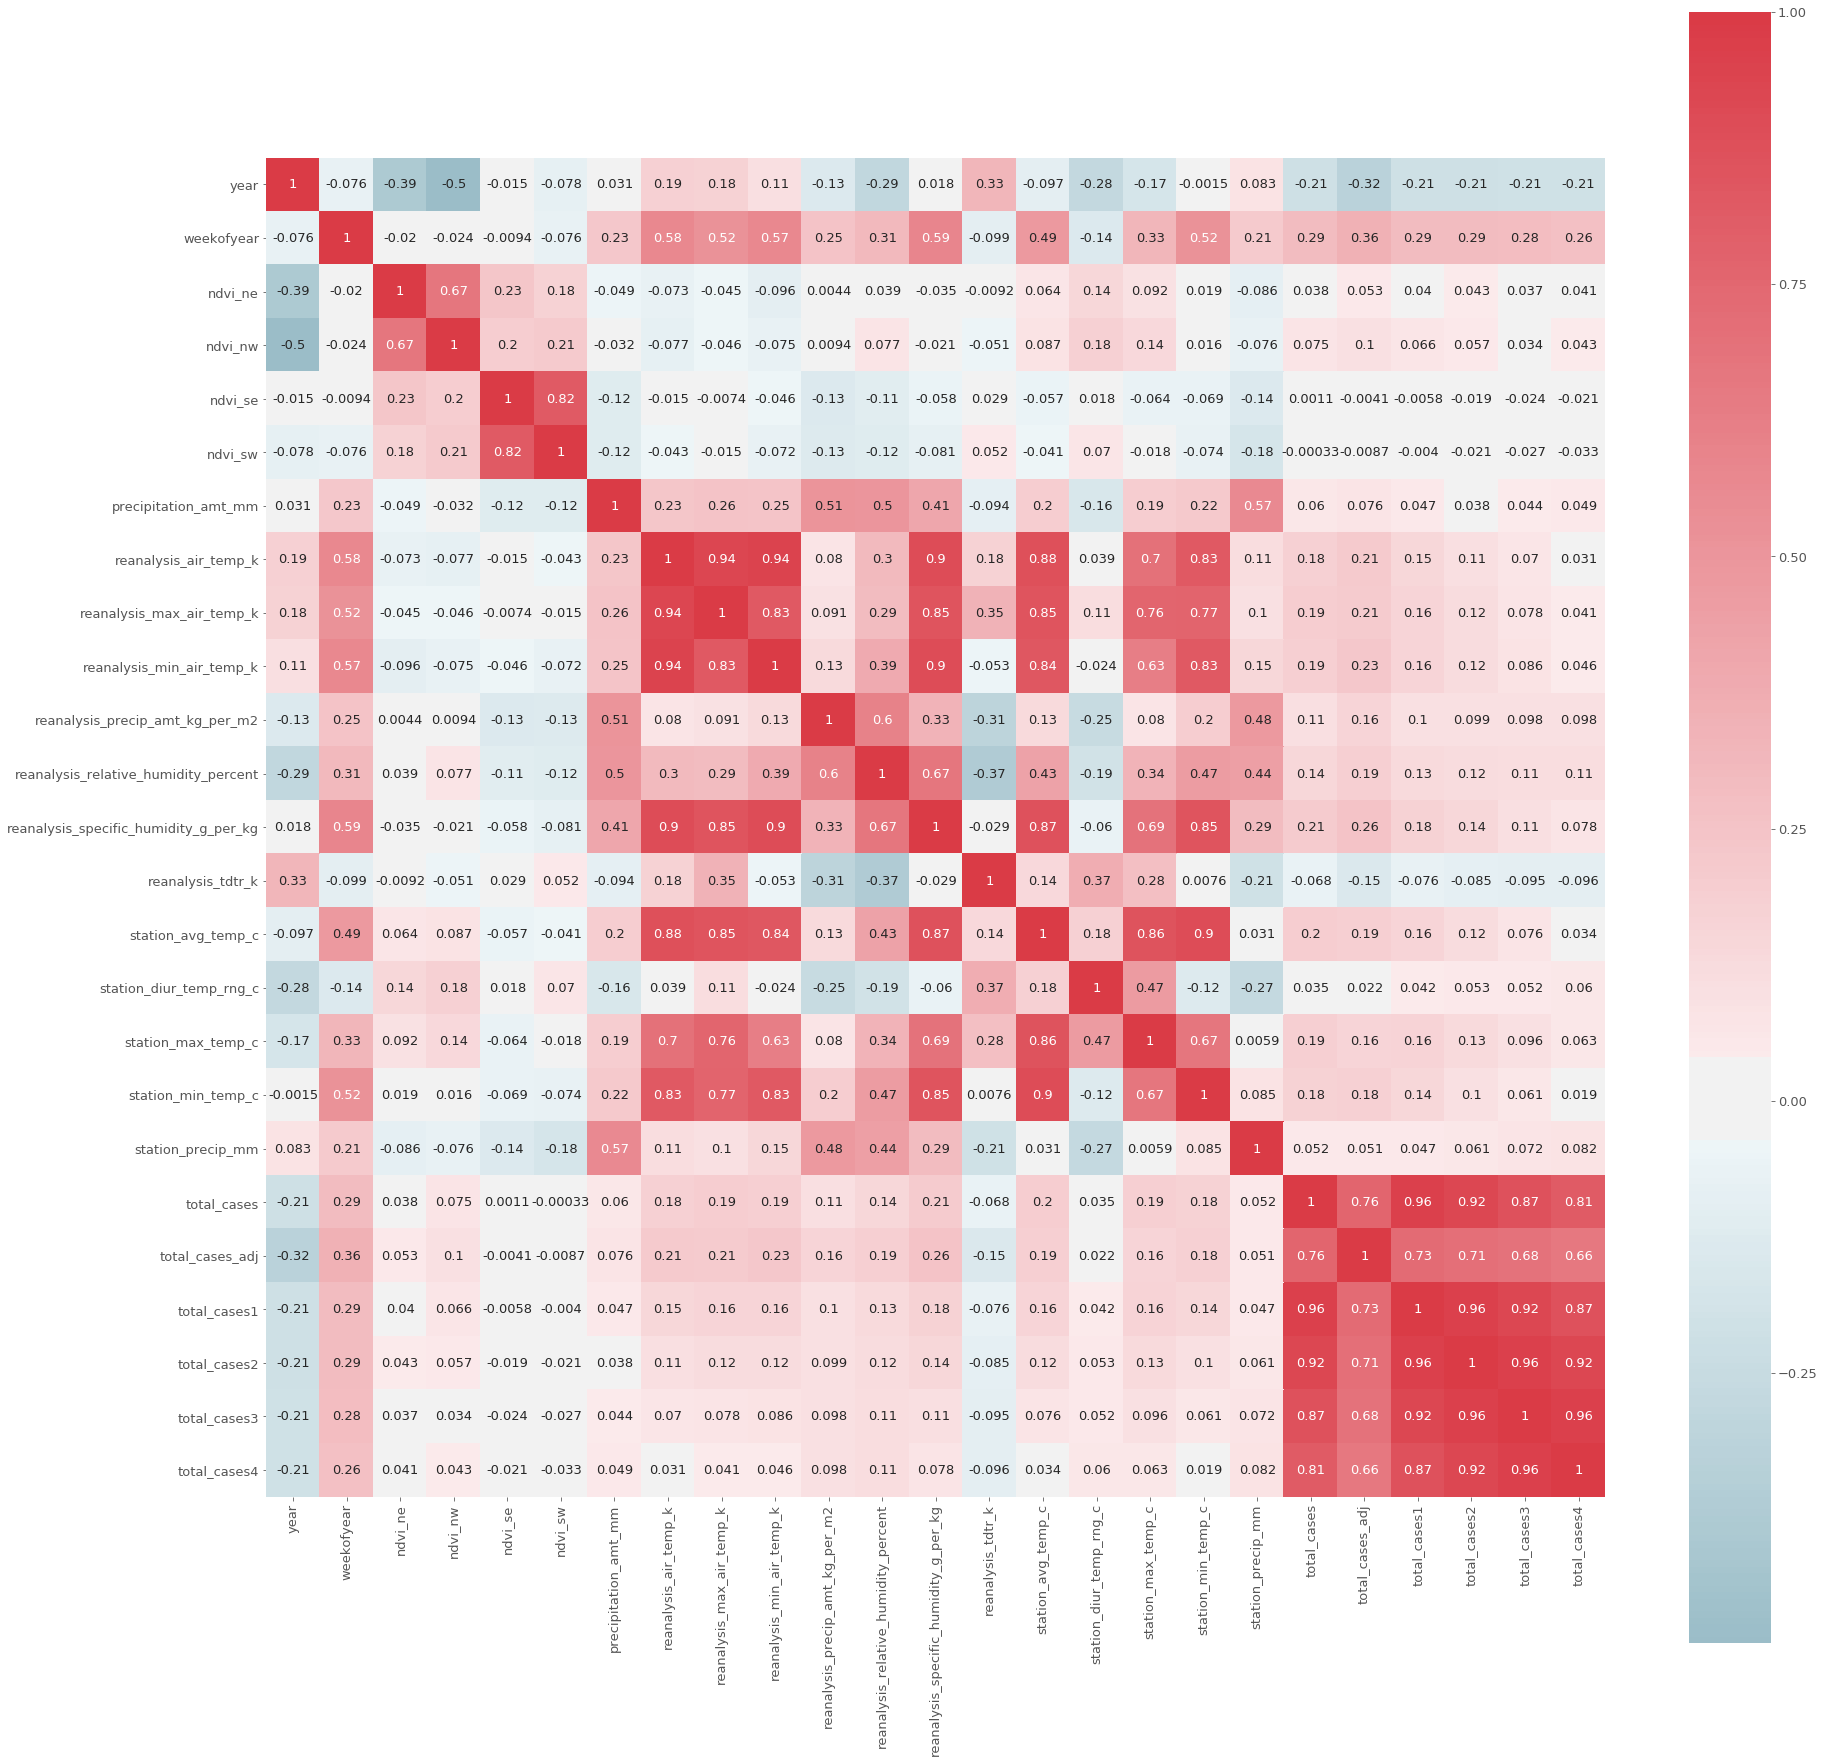

In [352]:
f, ax = plt.subplots(figsize=(30, 30))
corr = train_df[(train_df.city=='sj')].corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), 
            cmap=sns.diverging_palette(220, 10, as_cmap=True), annot=True, square=True, center=0, ax=ax)

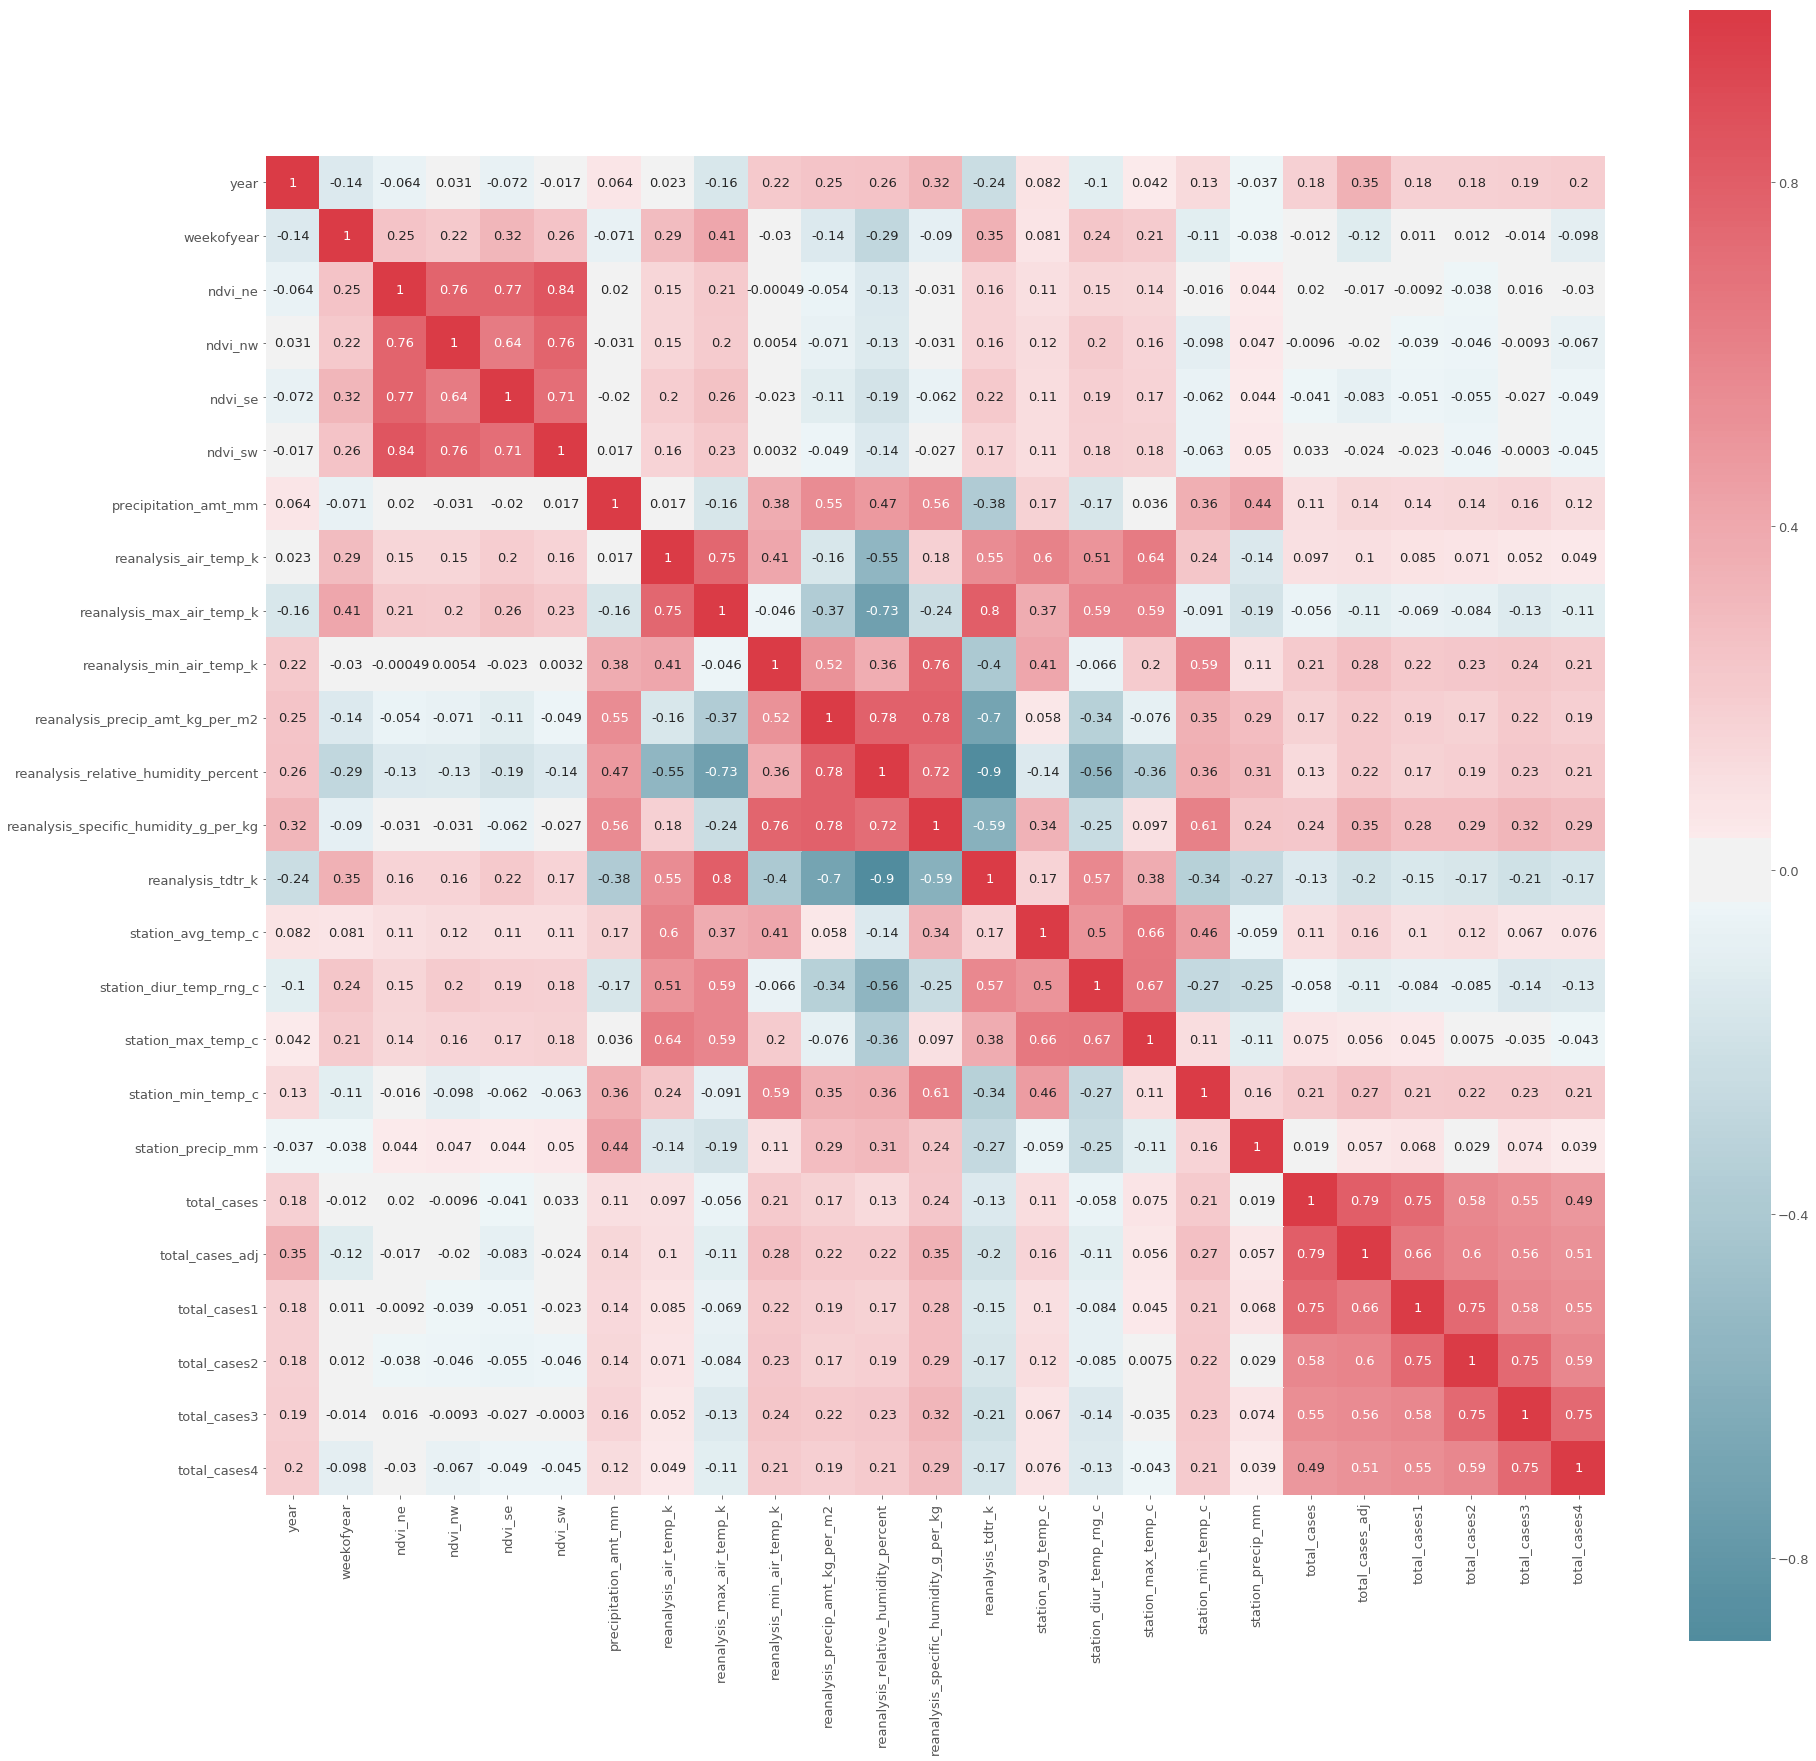

In [359]:
f, ax = plt.subplots(figsize=(30, 30))
corr = train_df[train_df.city=='iq'].corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), 
            cmap=sns.diverging_palette(220, 10, as_cmap=True), annot=True, center=0, square=True, ax=ax)

Удалим созданные сдвиговые переменные:

In [ ]:
del train_df['total_cases1']
del train_df['total_cases2']
del train_df['total_cases3']
del train_df['total_cases4']

---
Посмотрим теперь на распределение признаков:

Text(0.5,0,'station_precip_mm')

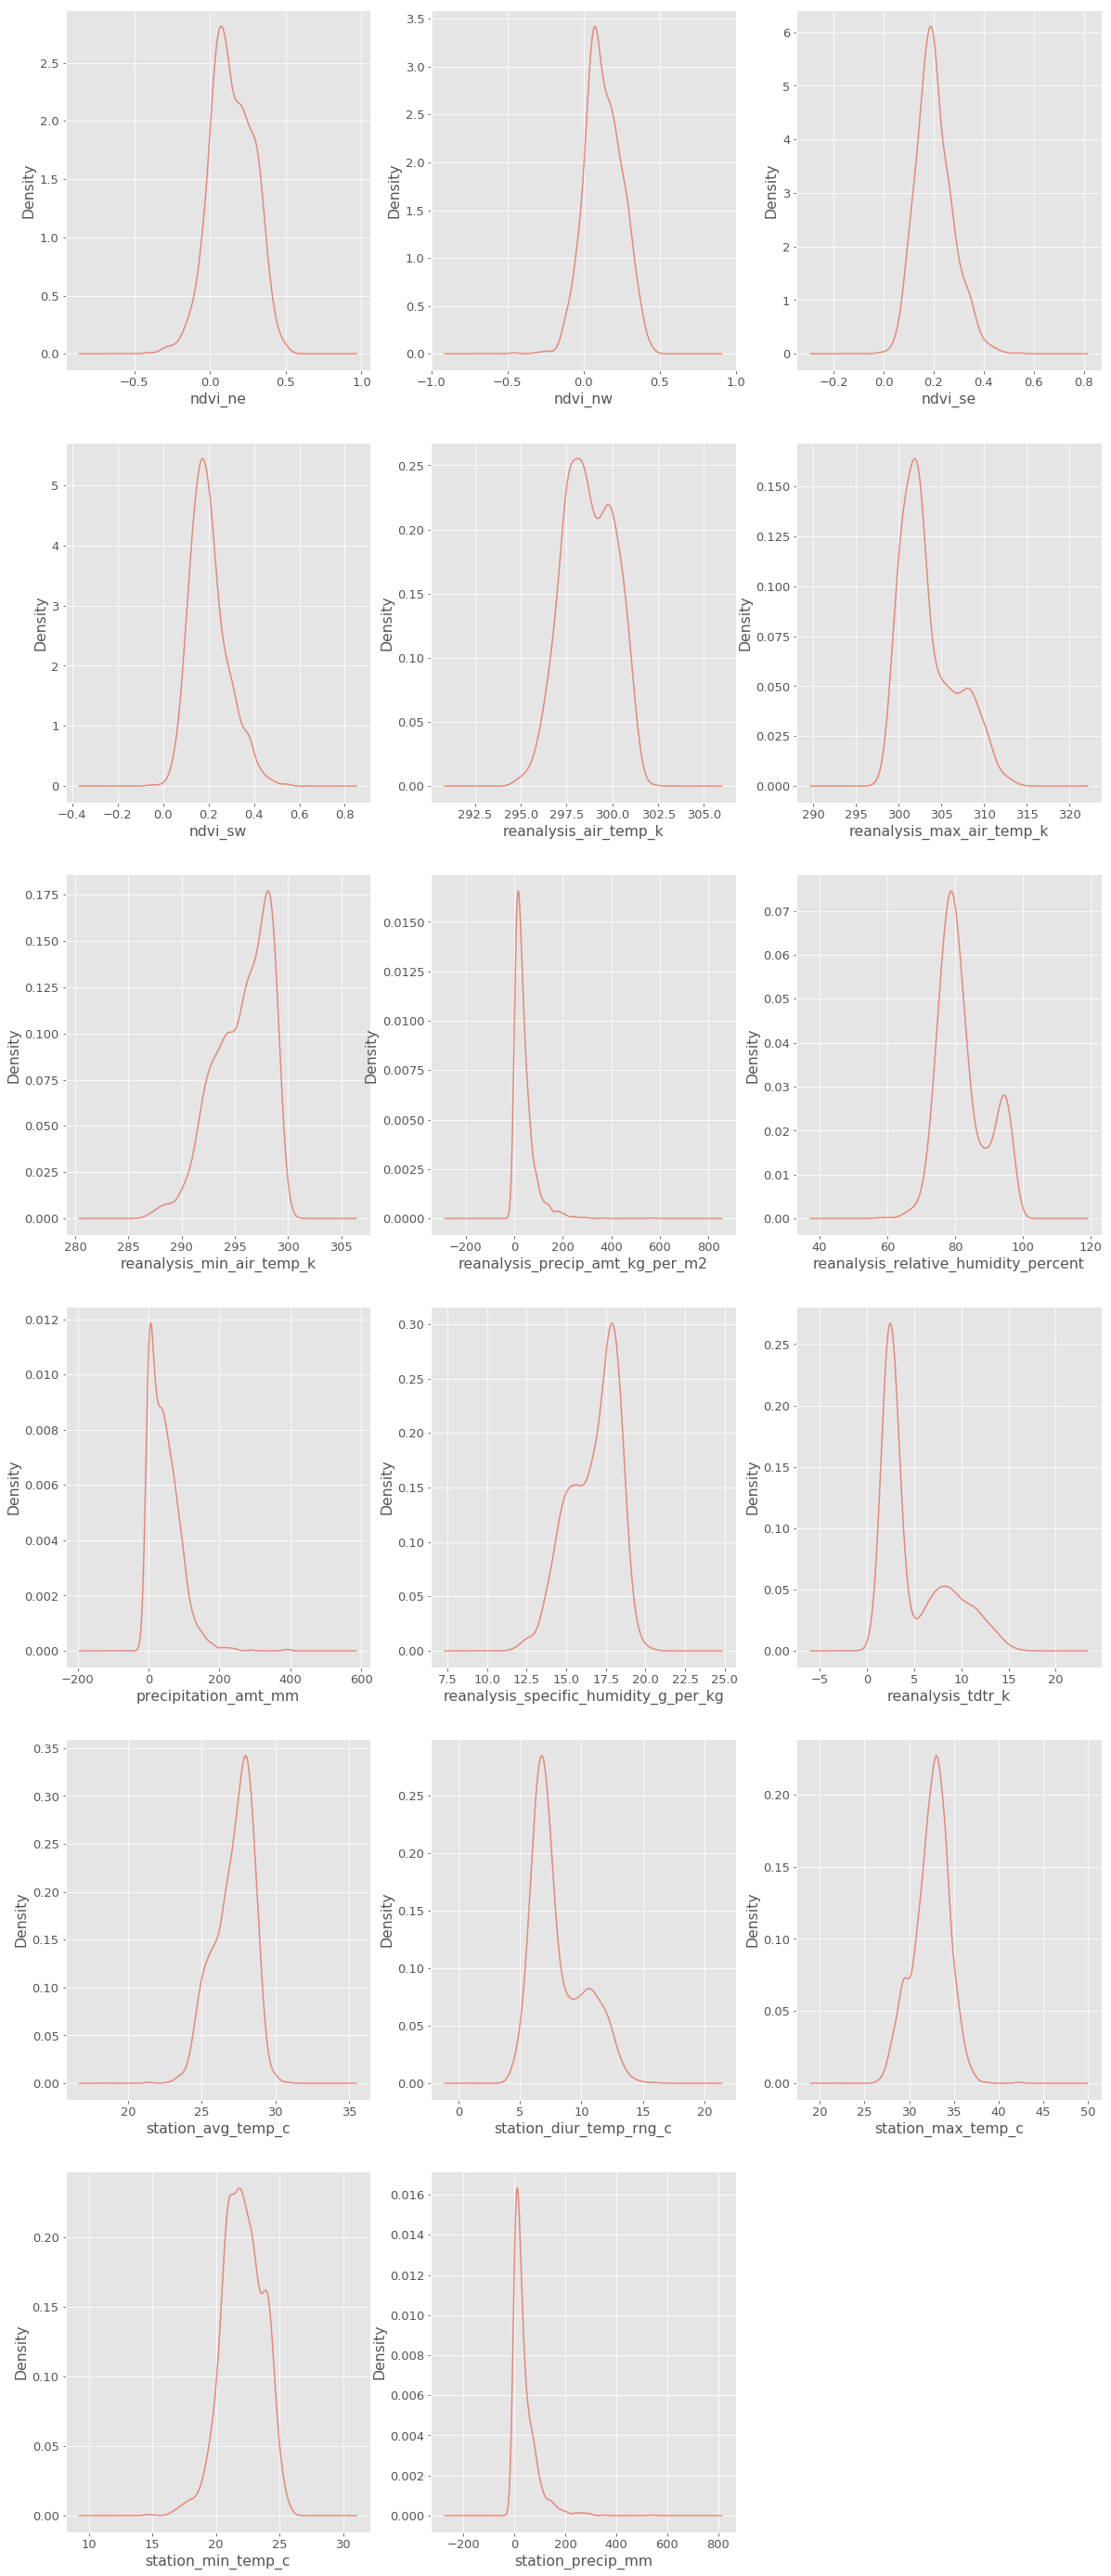

In [302]:
plt.rc("font", size=13)
plt.figure(figsize=(20,50))
alpha=0.6


ax1 = plt.subplot2grid((6,3), (0,0))
train_df.ndvi_ne.plot(kind="kde",alpha=alpha)
ax1.set_xlabel("ndvi_ne")

ax2 = plt.subplot2grid((6,3),(0,1))
train_df.ndvi_nw.plot(kind="kde",alpha=alpha)
ax2.set_xlabel("ndvi_nw")

ax3 = plt.subplot2grid((6,3),(0,2))
train_df.ndvi_se.plot(kind="kde",alpha=alpha)
ax3.set_xlabel("ndvi_se")

ax4 = plt.subplot2grid((6,3),(1,0))
train_df.ndvi_sw.plot(kind="kde",alpha=alpha)
ax4.set_xlabel("ndvi_sw")

ax5 = plt.subplot2grid((6,3),(1,1))
train_df.reanalysis_air_temp_k.plot(kind="kde",alpha=alpha)
ax5.set_xlabel("reanalysis_air_temp_k")

ax6 = plt.subplot2grid((6,3),(1,2))
train_df.reanalysis_max_air_temp_k.plot(kind="kde",alpha=alpha)
ax6.set_xlabel("reanalysis_max_air_temp_k")

ax7 = plt.subplot2grid((6,3),(2,0))
train_df.reanalysis_min_air_temp_k.plot(kind="kde",alpha=alpha)
ax7.set_xlabel("reanalysis_min_air_temp_k")

ax8 = plt.subplot2grid((6,3),(2,1))
train_df.reanalysis_precip_amt_kg_per_m2.plot(kind="kde",alpha=alpha)
ax8.set_xlabel("reanalysis_precip_amt_kg_per_m2")

ax9 = plt.subplot2grid((6,3),(2,2))
train_df.reanalysis_relative_humidity_percent.plot(kind="kde",alpha=alpha)
ax9.set_xlabel("reanalysis_relative_humidity_percent")

ax10 = plt.subplot2grid((6,3),(3,0))
train_df.precipitation_amt_mm.plot(kind="kde",alpha=alpha)
ax10.set_xlabel("precipitation_amt_mm")

ax11 = plt.subplot2grid((6,3),(3,1))
train_df.reanalysis_specific_humidity_g_per_kg.plot(kind="kde",alpha=alpha)
ax11.set_xlabel("reanalysis_specific_humidity_g_per_kg")

ax12 = plt.subplot2grid((6,3),(3,2))
train_df.reanalysis_tdtr_k.plot(kind="kde",alpha=alpha)
ax12.set_xlabel("reanalysis_tdtr_k")

ax13 = plt.subplot2grid((6,3),(4,0))
train_df.station_avg_temp_c.plot(kind="kde",alpha=alpha)
ax13.set_xlabel("station_avg_temp_c")

ax14 = plt.subplot2grid((6,3),(4,1))
train_df.station_diur_temp_rng_c.plot(kind="kde",alpha=alpha)
ax14.set_xlabel("station_diur_temp_rng_c")

ax15 = plt.subplot2grid((6,3),(4,2))
train_df.station_max_temp_c.plot(kind="kde",alpha=alpha)
ax15.set_xlabel("station_max_temp_c")

ax16 = plt.subplot2grid((6,3),(5,0))
train_df.station_min_temp_c.plot(kind="kde",alpha=alpha)
ax16.set_xlabel("station_min_temp_c")

ax17 = plt.subplot2grid((6,3),(5,1))
train_df.station_precip_mm.plot(kind="kde",alpha=alpha)
ax17.set_xlabel("station_precip_mm")

По своей природе признаки делятся на три части: уровень вегетации, температура, влажность и количество осадков. Для первых трех наблюдается распределение близкое к нормальному, а вот последняя группа имеет биномиальное распределение.

Воспользуемся логарифмированием для нормализации их распределения:

In [739]:
train_df.precipitation_amt_mm = train_df.precipitation_amt_mm.apply(math.log1p)
test_df.precipitation_amt_mm = test_df.precipitation_amt_mm.apply(math.log1p)
train_df.station_precip_mm = train_df.station_precip_mm.apply(math.log1p)
test_df.station_precip_mm = test_df.station_precip_mm.apply(math.log1p)

---

---

### 4. Инсайты, найденные зависимости

---

* Ни один из признаков не имеет сильной связи с целевой переменной
* Признаки температуры, что следует из природы признаков, сильно коррелируют

* учитывая разницу в расположении относительно моря, разброс температур и количество осадков значительно меньше в Сан-Хуане
* Наличие морского климата приводят к тому, что температура в Сан-Хуане изменяется слабо в течение дня, а абсолютная влажность движется вслед за температурой.
* а вот максимальное количество осадков больше все же в столице Пуэрто-Рико из-за расположения в зоне торнадо. 

Визуальный анализ:

* нормализованное распределение целевой переменной гораздо лучше коррелирует с большинством признаков, чем скошенное
* для Икитос четко прослеживается повышение корреляции признаков с целевой переменной при смещении на 1, 2 и 3 недели и небольшое падение на последнем сдвиге. А вот для Сан-Хуана отсутствие сдвига дает самую лучший набор корреляций целевой переменной с признаками. Так что для Икитос при построении модели имеет смысл сдвинуть наборы переменных на 3 недели назад.
* Сложно сказать, с чем связана закономерность из предыдущего пункта. Возможно, 
* не видно заметной зависимости числа заболеваний от уровня растительности. Учитывая информацию из Википедии, что основной источник размножения переносчиков заболевания - это стоячие водоемы вблизи/в жилых районах, данные признаки представляются несущественными и их можно удалить.
* Из двух признаков, характеризующих дневные колебания, reanalysis_tdtr_k показывает лучшую корреляцию. Удалим station_diur_temp_rng_c

In [740]:
del train_df['ndvi_ne']
del train_df['ndvi_nw']
del train_df['ndvi_sw']
del train_df['ndvi_se']
del train_df['station_diur_temp_rng_c']

del test_df['ndvi_ne']
del test_df['ndvi_nw']
del test_df['ndvi_sw']
del test_df['ndvi_se']
del test_df['station_diur_temp_rng_c']

---

---

### 5. Выбор метрики

---

Выбор метрики задан организаторами: средняя абсолютная ошибка(mean absolute error, MAE).
Она вычисляется по формуле:

$$\large \begin{array}{rcl}\mathcal{MAE} &=& \frac{1}{n} \sum_{i=1}^n \left |f_i - y_i \right|
\end{array}$$

Обоснование выбора именно этой метрики организаторами дано не было, однако можно предположить, что они сделали выбор, основываясь на главном преимуществе MAE - простоте интерпретации.  

Учитывая заявленное желание предсказывать эпидемии, использование средней квадратичной ошибки, которая гораздо лучше отслеживает выбросы, которыми являются вспышки эпидемий, было бы предпочтительнее.

---

---

### 6. Выбор модели

---

В рамках данного проекта нам необходимо решить задачу регрессии.  
Выбор ограничен сложными начальными условиями: небольшие набор данных и количество признаков.  

Как потенциальные варианты решения рассмотрим:  
* __Lasso Regression__ - регрессор c l1-регуляризацией  
* __XGBRegressor__ - регрессор, использующий деревья, на основе алгоритма xgboost.  

Посмотрим, какие результаты дадут модели на кросс-валидации и выберем лучшую.

---

---

### 7. Предобработка данных

---

In [806]:
cols = ['year', 'weekofyear', 'precipitation_amt_mm', 'reanalysis_air_temp_k', 'reanalysis_max_air_temp_k',
       'reanalysis_min_air_temp_k', 'reanalysis_precip_amt_kg_per_m2', 'reanalysis_relative_humidity_percent',
       'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k', 'station_avg_temp_c', 'station_max_temp_c', 
        'station_min_temp_c', 'station_precip_mm', 'total_cases', 'total_cases_adj']

features_to_scale = ['year', 'weekofyear', 'precipitation_amt_mm', 'reanalysis_air_temp_k', 'reanalysis_max_air_temp_k', 
                     'reanalysis_min_air_temp_k', 'reanalysis_precip_amt_kg_per_m2', 
                     'reanalysis_relative_humidity_percent', 'reanalysis_specific_humidity_g_per_kg', 
                     'reanalysis_tdtr_k', 'station_avg_temp_c', 'station_max_temp_c', 
                     'station_min_temp_c', 'station_precip_mm']

Разделим данные по городам:

In [807]:
sj_df = pd.concat([train_df[train_df.city=='sj'].copy(), test_df[test_df.city=='sj'].copy()])

iq_df = pd.concat([train_df[train_df.city=='iq'].copy(), test_df[test_df.city=='iq'].copy()])

In [808]:
sj_df = sj_df.drop(['city'], axis=1)
iq_df = iq_df.drop(['city'], axis=1)

In [809]:
id_sj = train_df[train_df.city=='sj'].shape[0]
id_iq = train_df[train_df.city=='iq'].shape[0]
vid_sj = int(0.7*id_sj)
vid_iq = int(0.7*id_iq)

Сдвинем данные для Икитос на 3 недели назад. Образовавшийся пробел ввиду природы данных лучше заполнить последними значениями. Оставим также изначальный вариант, чтобы проверить гипотезу о сдвиге.

In [810]:
iq_base_df = iq_df.copy()
iq_df[cols] = iq_df[cols].shift(-3)

iq_df.iloc[iq_df.shape[0]-3] = iq_df.iloc[iq_df.shape[0]-4].values
iq_df.iloc[iq_df.shape[0]-2] = iq_df.iloc[iq_df.shape[0]-4].values
iq_df.iloc[iq_df.shape[0]-1] = iq_df.iloc[iq_df.shape[0]-4].values

Заполним пропущенные данные методом заполнения вперед: 

In [811]:
sj_df.fillna(method='ffill', inplace=True)
iq_df.fillna(method='ffill', inplace=True)
iq_base_df.fillna(method='ffill', inplace=True)

Отмасштабируем признаки:

In [812]:
scaler = StandardScaler()
features_scaled_sj = sj_df[features_to_scale].values
sjx_train = scaler.fit_transform(features_scaled_sj[:id_sj])
sjx_test = scaler.transform(features_scaled_sj[id_sj:])
sj_df[features_to_scale] = np.concatenate([sjx_train, sjx_test])

features_scaled_iq = iq_df[features_to_scale].values
iqx_train = scaler.fit_transform(features_scaled_iq[:id_iq])
iqx_test = scaler.transform(features_scaled_iq[id_iq:])
iq_df[features_to_scale] = np.concatenate([iqx_train, iqx_test])

features_scaled_iq_base = iq_base_df[features_to_scale].values
iq_base_train = scaler.fit_transform(features_scaled_iq_base[:id_iq])
iq_base_test = scaler.transform(features_scaled_iq_base[id_iq:])
iq_base_df[features_to_scale] = np.concatenate([iq_base_train, iq_base_test])

Учитывая, что мы имеем дело с временным рядом, корректным является только выделение валидационной выборки из конца обучающей:

In [923]:
sjx_valid_df = pd.DataFrame(sjx_train[vid_sj:id_sj], columns=features_to_scale)
sjx_valid_df['y'] = sj_df.total_cases[vid_sj:id_sj].values
sjx_valid_df['y_adj'] = sj_df.total_cases_adj[vid_sj:id_sj].values

sjx_train_df = pd.DataFrame(sjx_train[:vid_sj], columns=features_to_scale)
sjx_train_df['y'] = sj_df.total_cases[:vid_sj].values
sjx_train_df['y_adj'] = sj_df.total_cases_adj[:vid_sj].values

sjx_test_df = pd.DataFrame(sjx_test, columns=features_to_scale)

iqx_valid_df = pd.DataFrame(iqx_train[vid_iq:id_iq], columns=features_to_scale)
iqx_valid_df['y'] = iq_df.total_cases[vid_iq:id_iq].values
iqx_valid_df['y_adj'] = iq_df.total_cases_adj[vid_iq:id_iq].values

iqx_train_df = pd.DataFrame(iqx_train[:vid_iq], columns=features_to_scale)
iqx_train_df['y'] = iq_df.total_cases[:vid_iq].values
iqx_train_df['y_adj'] = iq_df.total_cases_adj[:vid_iq].values

iqx_test_df = pd.DataFrame(iqx_test, columns=features_to_scale)

iqx_base_valid_df = pd.DataFrame(iq_base_train[vid_iq:id_iq], columns=features_to_scale)
iqx_base_valid_df['y'] = iq_base_df.total_cases[vid_iq:id_iq].values
iqx_base_valid_df['y_adj'] = iq_base_df.total_cases_adj[vid_iq:id_iq].values

iqx_base_train_df = pd.DataFrame(iq_base_train[:vid_iq], columns=features_to_scale)
iqx_base_train_df['y'] = iq_base_df.total_cases[:vid_iq].values
iqx_base_train_df['y_adj'] = iq_base_df.total_cases_adj[:vid_iq].values

iqx_base_test_df = pd.DataFrame(iq_base_test, columns=features_to_scale)

---

---

### 8. Кросс-валидация и настройка гиперпараметров модели (4 балла)

    (+) Кросс-валидация выполнена технически верно, нет утечек данных. Разумно выбрано количество фолдов и разбиение (Random/Stratified или иное), зафиксирован seed. Присутствует объяснение. Объяснены гиперпараметры модели и способ их выбора. Выбор основан на некотором исследовании гипрепараметров модели для данной задачи;
    
    (+/-) Присутствуют незначительные ошибки (например, не зафиксирован seed) или отсутствует объяснение кросс-валидации. Но гиперпараметры модели и способ их выбора должны быть объяснены;
    
    (-/+) Кросс-валидация выполнена со значительными ошибками (например, преобразования данных проводится на всей выборке, таким образом возникает утечка данных из тестовой части выборки и, соответственно, результат кросс-валидации может иметь слишком оптимистичное значение). Гиперпараметры модели и способ их выбора не объяснены;
    
    (-) Отсутствуют.

---

Выделим обучающую и тестовую выборки, а также целевую переменную для трех наборов данных:

In [933]:
X_sj = sj_df.iloc[:id_sj].drop(['total_cases', 'total_cases_adj'], axis=1)
y_sj = sj_df.iloc[:id_sj].total_cases_adj
y_true_sj = sj_df['total_cases'].iloc[:id_sj]
test_sj = sj_df.iloc[id_sj:].drop(['total_cases', 'total_cases_adj'], axis=1)

X_iq = iq_df.iloc[:id_iq].drop(['total_cases', 'total_cases_adj'], axis=1)
y_iq = iq_df.iloc[:id_iq].total_cases_adj
y_true_iq = iq_df['total_cases'].iloc[:id_iq]
test_iq = iq_df.iloc[id_iq:].drop(['total_cases', 'total_cases_adj'], axis=1)

X_iq_base = iq_base_df.iloc[:id_iq].drop(['total_cases', 'total_cases_adj'], axis=1)
y_iq_base = iq_base_df.iloc[:id_iq].total_cases_adj
y_true_iq_base = iq_base_df['total_cases'].iloc[:id_iq]
test_iq_base = iq_base_df.iloc[id_iq:].drop(['total_cases', 'total_cases_adj'], axis=1)

Будем производить поиск гиперпараметров XGBRegressor с помощью GridSearchCV, используя методику TimeSeriesSplit для осуществления кросс-валидации.

Также будем осуществлять поиск лучшего набора признаков при помощи метода SFS библиотеки mlxtend.

In [854]:
tss = TimeSeriesSplit(n_splits=10)
set_params = {'n_estimators': [100, 200, 400],
              'learning_rate': [0.1, 0.3, 0.5, 1],
              'max_depth': [4, 5, 6]
             }
clf_xgb = xgb.XGBRegressor(objective='reg:linear', seed=13)
grid = GridSearchCV(clf_xgb, 
                    set_params,
                    cv=tss, 
                    scoring='neg_mean_absolute_error',
                    n_jobs=-1
                   )

In [899]:
grid.fit(X_sj, y_sj)
sj_best = grid.best_estimator_
pred_sj = sj_best.predict(test_sj)

SFS1 = SFS(sj_best, k_features=(1, 14), forward=True, floating=True,
           verbose=1, scoring='neg_mean_absolute_error', cv=tss, n_jobs=-1)
sfs1 = SFS1.fit(X_sj.as_matrix(), y_sj)
print([X_sg.columns[i-1] for i in sfs1.k_features])
print(sfs1.k_score_)

[Parallel(n_jobs=-1)]: Done   4 out of  14 | elapsed:   39.3s remaining:  1.6min
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:   41.8s finished
Features: 1/14[Parallel(n_jobs=-1)]: Done  13 out of  13 | elapsed:   45.5s finished
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished
Features: 2/14[Parallel(n_jobs=-1)]: Done   9 out of  12 | elapsed:   44.0s remaining:   14.7s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:   44.4s finished
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    6.1s finished
Features: 3/14[Parallel(n_jobs=-1)]: Done   4 out of  11 | elapsed:   41.9s remaining:  1.2min
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:   43.2s finished
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   10.8s finished
Features: 4/14[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   42.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   42.0s finished
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed

['precipitation_amt_mm', 'year']
-0.748872825347


In [900]:
grid.fit(X_iq, y_iq)
iq_best = grid.best_estimator_
pred_iq = iq_best.predict(test_iq)
print(grid.best_score_)

SFS2 = SFS(iq_best, k_features=(1, 14), forward=True, floating=True,
           verbose=1, scoring='neg_mean_absolute_error', cv=tss, n_jobs=-1)
sfs2 = SFS2.fit(X_iq.as_matrix(), y_iq)
print([X_iq.columns[i-1] for i in sfs2.k_features])
print(sfs2.k_score_)

-0.837133767676


[Parallel(n_jobs=-1)]: Done   4 out of  14 | elapsed:    9.8s remaining:   24.5s
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:   10.7s finished
Features: 1/14[Parallel(n_jobs=-1)]: Done  13 out of  13 | elapsed:   10.6s finished
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.4s finished
Features: 2/14[Parallel(n_jobs=-1)]: Done   9 out of  12 | elapsed:   10.3s remaining:    3.4s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:   10.5s finished
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.8s finished
Features: 3/14[Parallel(n_jobs=-1)]: Done   4 out of  11 | elapsed:    9.4s remaining:   16.4s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:   10.0s finished
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.7s finished
Features: 4/14[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    9.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    9.3s finished
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed

['precipitation_amt_mm', 'year']
-0.826405815374


In [901]:
grid.fit(X_iq_base, y_iq_base)
iq_base_best = grid.best_estimator_
pred_iq_base = iq_base_best.predict(test_iq_base)
print(grid.best_score_)

SFS3 = SFS(iq_base_best, k_features=(1, 14), forward=True, floating=True,
           verbose=1, scoring='neg_mean_absolute_error', cv=tss, n_jobs=-1)
sfs3 = SFS3.fit(X_iq_base.as_matrix(), y_iq_base)
print([X_iq_base.columns[i-1] for i in sfs3.k_features])
print(sfs3.k_score_)

-0.812549708439


[Parallel(n_jobs=-1)]: Done   4 out of  14 | elapsed:   10.5s remaining:   26.2s
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:   11.1s finished
Features: 1/14[Parallel(n_jobs=-1)]: Done  13 out of  13 | elapsed:   11.1s finished
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.5s finished
Features: 2/14[Parallel(n_jobs=-1)]: Done   9 out of  12 | elapsed:   10.1s remaining:    3.4s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:   10.4s finished
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.5s finished
Features: 3/14[Parallel(n_jobs=-1)]: Done   4 out of  11 | elapsed:    9.3s remaining:   16.3s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    9.8s finished
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.7s finished
Features: 4/14[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    9.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    9.3s finished
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed

['precipitation_amt_mm', 'year']
-0.757256776343


Мы получили интересный результат: кросс-валидация показала, что для обоих городов лучший набор признаков - это ['precipitation_amt_mm', 'year'].

Гипотеза о том, что несмещенные признаки хуже для Икитос не подтверждается.

Построим модель с новыми признаками и узнаем значение метрики для нее:

In [906]:
grid.fit(X_sj[['precipitation_amt_mm', 'year']], y_sj)
pred_sj = grid.best_estimator_.predict(test_sj[['precipitation_amt_mm', 'year']])

grid.fit(X_iq_base[['precipitation_amt_mm', 'year']], y_iq_base)
pred_iq_base = grid.best_estimator_.predict(test_iq_base[['precipitation_amt_mm', 'year']])

In [907]:
base1 = pd.read_csv('/media/sadworker/DataRed/data/dengai/submission.csv', index_col=[0, 1, 2])

In [908]:
base1.total_cases = np.concatenate([np.round(np.exp(pred_sj) - 1).astype(int), 
                                   np.round(np.exp(pred_iq_base) - 1).astype(int)])

In [909]:
base1.to_csv('/media/sadworker/DataRed/data/dengai/subm1imp.csv')

Попробуем использовать в качестве обучающей выборку из 4 наиболее коррелирующих с целевым признаков:

In [917]:
sj_best.fit(X_sj[['year', 'reanalysis_min_air_temp_k', 
              'reanalysis_precip_amt_kg_per_m2', 'station_min_temp_c']], y_sj)
pred2_sj = sj_best.predict(test_sj[['year', 'reanalysis_min_air_temp_k', 
                                   'reanalysis_precip_amt_kg_per_m2', 'station_min_temp_c']])

In [918]:
iq_base_best.fit(X_iq_base[['year', 'reanalysis_min_air_temp_k', 
                    'reanalysis_precip_amt_kg_per_m2', 'station_min_temp_c']], y_iq_base)
pred2_iq_base = iq_base_best.predict(test_iq_base[['year', 'reanalysis_min_air_temp_k', 
                                                   'reanalysis_precip_amt_kg_per_m2', 'station_min_temp_c']])

In [919]:
base2 = pd.read_csv('/media/sadworker/DataRed/data/dengai/submission.csv', index_col=[0, 1, 2])

In [921]:
base2.total_cases = np.concatenate([np.round(np.exp(pred2_sj) - 1).astype(int), 
                                   np.round(np.exp(pred2_iq_base) - 1).astype(int)])

In [922]:
base2.to_csv('/media/sadworker/DataRed/data/dengai/subm1corr.csv')

Повторим те же операции, но уже с моделью Лассо:

In [910]:
set_params = {'alpha': np.logspace(-10, 4, 50)}
clf_lasso = Lasso(random_state = 13)
gridl = GridSearchCV(clf_lasso, 
                    set_params,
                    cv=tss, 
                    scoring='neg_mean_absolute_error',
                    n_jobs=-1
                   )

In [911]:
gridl.fit(X_sj, y_sj)
predl_sj = gridl.best_estimator_.predict(test_sj)

SFSl1 = SFS(gridl.best_estimator_, k_features=(1, 14), forward=True, floating=True,
           verbose=1, scoring='neg_mean_absolute_error', cv=tss, n_jobs=-1)
sfsl1 = SFSl1.fit(X_sj.as_matrix(), y_sj)
print([X_sg.columns[i-1] for i in sfsl1.k_features])
print(sfsl1.k_score_)

[Parallel(n_jobs=-1)]: Done   4 out of  14 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:    0.4s finished
Features: 1/14[Parallel(n_jobs=-1)]: Done  13 out of  13 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished
Features: 2/14[Parallel(n_jobs=-1)]: Done   9 out of  12 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.1s finished
Features: 3/14[Parallel(n_jobs=-1)]: Done   4 out of  11 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
Features: 4/14[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed

['precipitation_amt_mm', 'year']
-0.781552443424


In [912]:
gridl.fit(X_iq, y_iq)
predl_iq = gridl.best_estimator_.predict(test_iq)
print(grid.best_score_)

SFSl2 = SFS(gridl.best_estimator_, k_features=(1, 14), forward=True, floating=True,
           verbose=1, scoring='neg_mean_absolute_error', cv=tss, n_jobs=-1)
sfsl2 = SFSl2.fit(X_iq.as_matrix(), y_iq)
print([X_iq.columns[i-1] for i in sfsl2.k_features])
print(sfsl2.k_score_)

-0.782364477951


[Parallel(n_jobs=-1)]: Done   4 out of  14 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:    0.4s finished
Features: 1/14[Parallel(n_jobs=-1)]: Done  13 out of  13 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished
Features: 2/14[Parallel(n_jobs=-1)]: Done   9 out of  12 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
Features: 3/14[Parallel(n_jobs=-1)]: Done   4 out of  11 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
Features: 4/14[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed

['precipitation_amt_mm', 'year']
-0.859314278209


In [913]:
gridl.fit(X_iq_base, y_iq_base)
predl_iq_base = gridl.best_estimator_.predict(test_iq_base)
print(gridl.best_score_)

SFSl3 = SFS(gridl.best_estimator_, k_features=(1, 14), forward=True, floating=True,
           verbose=1, scoring='neg_mean_absolute_error', cv=tss, n_jobs=-1)
sfsl3 = SFSl3.fit(X_iq_base.as_matrix(), y_iq_base)
print([X_iq_base.columns[i-1] for i in sfsl3.k_features])
print(sfsl3.k_score_)

-0.885594987628


[Parallel(n_jobs=-1)]: Done   4 out of  14 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:    0.4s finished
Features: 1/14[Parallel(n_jobs=-1)]: Done  13 out of  13 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished
Features: 2/14[Parallel(n_jobs=-1)]: Done   9 out of  12 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.1s finished
Features: 3/14[Parallel(n_jobs=-1)]: Done   4 out of  11 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.2s finished
Features: 4/14[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10

['precipitation_amt_mm', 'year']
-0.868973286542


Лассо уступает xgboost на кросс-валидации.

---

---

### 9. Прогноз для тестовой или отложенной выборки (2 балла)

    (+) Указаны результаты на тестовой выборке или LB score. Результаты на тестовой выборке сравнимы с результатами на кросс-валидации. Если тестовая выборка создавалась автором проекта, то механизм создания должен быть непредвзят и объяснен (применен разумный механизм выборки, в простейшем случае – рандомизация);
    
    (+/-) Значения метрик на тестовой выборке не сильно отличаются от значений метрик на кросс-валидации и/или тестовая выборка создана предвзято, но есть разумное обоснование этому (пример: заказчик взял тестовую выборку из другого распределения);
    
    (-/+) Значения метрик на тестовой выборке сильно отличаются от значений метрик на кросс-валидации и/или тестовая выборка создана предвзято;
    
    (-) Прогноз для тестовой или отложенной выборки отсутствует.

Модель xgbregressor со всеми признаками показала наилучший результат: MAE=27.6514.

Модель с двумя признаками, отобранными с помощью mlxtend не дала улучшения: MAE=34.0433

Модель с коррелирующими признаками дала: MAE=30.1058

Модель Лассо отстает от xgb на 2-4 единицы по метрике по всем наборам признаков

Посмотрим на результаты по отложенной выборке:

In [ ]:
sjx_valid_df = pd.DataFrame(sjx_train[vid_sj:id_sj], columns=features_to_scale)
sjx_valid_df['y'] = sj_df.total_cases[vid_sj:id_sj].values
sjx_valid_df['y_adj'] = sj_df.total_cases_adj[vid_sj:id_sj].values

sjx_train_df = pd.DataFrame(sjx_train[:vid_sj], columns=features_to_scale)
sjx_train_df['y'] = sj_df.total_cases[:vid_sj].values
sjx_train_df['y_adj'] = sj_df.total_cases_adj[:vid_sj].values

sjx_test_df = pd.DataFrame(sjx_test, columns=features_to_scale)

iqx_valid_df = pd.DataFrame(iqx_train[vid_iq:id_iq], columns=features_to_scale)
iqx_valid_df['y'] = iq_df.total_cases[vid_iq:id_iq].values
iqx_valid_df['y_adj'] = iq_df.total_cases_adj[vid_iq:id_iq].values

iqx_train_df = pd.DataFrame(iqx_train[:vid_iq], columns=features_to_scale)
iqx_train_df['y'] = iq_df.total_cases[:vid_iq].values
iqx_train_df['y_adj'] = iq_df.total_cases_adj[:vid_iq].values

iqx_test_df = pd.DataFrame(iqx_test, columns=features_to_scale)

iqx_base_valid_df = pd.DataFrame(iq_base_train[vid_iq:id_iq], columns=features_to_scale)
iqx_base_valid_df['y'] = iq_base_df.total_cases[vid_iq:id_iq].values
iqx_base_valid_df['y_adj'] = iq_base_df.total_cases_adj[vid_iq:id_iq].values

iqx_base_train_df = pd.DataFrame(iq_base_train[:vid_iq], columns=features_to_scale)
iqx_base_train_df['y'] = iq_base_df.total_cases[:vid_iq].values
iqx_base_train_df['y_adj'] = iq_base_df.total_cases_adj[:vid_iq].values

iqx_base_test_df = pd.DataFrame(iq_base_test, columns=features_to_scale)

In [931]:
sj_best.fit(sjx_train_df.drop(['y', 'y_adj'], axis=1), sjx_train_df['y_adj'])
valf_sj = sj_best.predict(sjx_valid_df.drop(['y', 'y_adj'], axis=1))
print('МАЕ на отложенной выборке для всех признаков и Сан-Хуана равно:%0.3f' % mean_absolute_error(sjx_valid_df['y'],
                                                                                                np.exp(valf_sj)-1))

МАЕ на отложенной выборке для всех признаков и Сан-Хуана равно:17.185


In [932]:
iq_base_best.fit(iqx_base_train_df.drop(['y', 'y_adj'], axis=1), iqx_base_train_df['y_adj'])
valf_iq_base = iq_base_best.predict(iqx_base_valid_df.drop(['y', 'y_adj'], axis=1))
print('МАЕ на отложенной выборке для всех признаков и Икитос равно:%0.3f' % mean_absolute_error(iqx_base_valid_df['y'],
                                                                                             np.exp(valf_iq_base)-1))

МАЕ на отложенной выборке для всех признаков и Икитос равно:7.141


In [928]:
sj_best.fit(sjx_train_df[['precipitation_amt_mm', 'year']], sjx_train_df['y_adj'])
val2_sj = sj_best.predict(sjx_valid_df[['precipitation_amt_mm', 'year']])
print('МАЕ на отложенной выборке для 2 признаков и Сан-Хуана равно:%0.3f' % mean_absolute_error(sjx_valid_df['y'],
                                                                                                np.exp(val2_sj)-1))

МАЕ на отложенной выборке для 2 признаков и Сан-Хуана равно:16.717


In [929]:
iq_base_best.fit(iqx_base_train_df[['precipitation_amt_mm', 'year']], iqx_base_train_df['y_adj'])
val2_iq_base = iq_base_best.predict(iqx_base_valid_df[['precipitation_amt_mm', 'year']])
print('МАЕ на отложенной выборке для 2 признаков и Икитос равно:%0.3f' % mean_absolute_error(iqx_base_valid_df['y'],
                                                                               np.exp(val2_iq_base)-1))

МАЕ на отложенной выборке для 2 признаков и Икитос равно:7.638


In [925]:
sj_best.fit(sjx_train_df[['year', 'reanalysis_min_air_temp_k', 
                          'reanalysis_precip_amt_kg_per_m2', 'station_min_temp_c']], sjx_train_df['y_adj'])
val4_sj = sj_best.predict(sjx_valid_df[['year', 'reanalysis_min_air_temp_k', 
                                        'reanalysis_precip_amt_kg_per_m2', 'station_min_temp_c']])
print('МАЕ на отложенной выборке для 4 признаков и Сан-Хуана равно:%0.3f' % mean_absolute_error(sjx_valid_df['y'],
                                                                                                np.exp(val4_sj)-1))

МАЕ на отложенной выборке для Сан-Хуана равно:16.749


In [927]:
iq_base_best.fit(iqx_base_train_df[['year', 'reanalysis_min_air_temp_k', 
                                    'reanalysis_precip_amt_kg_per_m2', 'station_min_temp_c']], iqx_base_train_df['y_adj'])
val4_iq_base = iq_base_best.predict(iqx_base_valid_df[['year', 'reanalysis_min_air_temp_k', 
                                                       'reanalysis_precip_amt_kg_per_m2', 'station_min_temp_c']])
print('МАЕ на отложенной выборке для 4 признаков и Икитос равно:%0.3f' % mean_absolute_error(iqx_base_valid_df['y'],
                                                                                             np.exp(val4_iq_base)-1))

МАЕ на отложенной выборке для Икитос равно:7.286


Таким образом, результаты на отложенной выборке показывают плохую корреляцию с тестовыми данными.

В условиях малой выборки и шумных данных единственным способом повышать результат видится валидирование по Leaderboard.

---

---

### 10. Выводы

---

В рамках проекта исследованы предоставленные данные, выявлены отдельные тренды и использованы 2 модели с подбором гиперпараметров.

На данный момент результат на Leaderboard очень посредственный - только топ-75%. В процессе кросс-валидации сделан вывод о ее сомнительной ценности для решения данной задачи.

В дальнейшем стоит:
* продолжить исследование, связанное со сдвигом данных относительно целевой переменной, ведь для этого есть теоретическое обоснование
* исследовать и попытаться внести в модель выявленную цикличность целевой переменной в течение года, а также межгодовые тренды. Возможно, просто применить статистические методы.
* рассмотреть использование ансамбля моделей